# EvoGFuzz: An Evolutionary Approach to Grammar-Based Fuzzing

**EvoGFuzz** stands for *evolutionary grammar-based fuzzing*. This approach leverages evolutionary optimization techniques to systematically explore the space of a program's potential inputs, with a particular emphasis on identifying inputs that could lead to exceptional behavior. With a user-defined objective, EvoGFuzz can adapt and refine the input generation strategy over time, making it a powerful tool for uncovering software defects and vulnerabilities.

Efficient detection of defects and vulnerabilities hinges on the ability to automatically generate program inputs that are both valid and diverse. One common strategy is to use grammars, which provide structured and syntactically correct inputs. This approach leads to the concept of grammar-based fuzzing, where fuzzing strategies are guided by the rules defined within the grammar.

A further enhancement to this concept is probabilistic grammar-based fuzzing, where competing grammar rules are associated with probabilities that guide their application. By carefully assigning and optimizing these probabilities, we gain considerable control over the nature of the generated inputs. This enables us to direct the fuzzing process towards specific areas of interest—for example, those functions that are deemed critical, have a higher propensity for failures, or have undergone recent modifications. 

In essence, EvoGFuzz represents a potent blend of evolutionary optimization and probabilistic grammar-based fuzzing, poised to reveal hidden defects and vulnerabilities in a targeted and efficient manner.

## Fuzzing a Program

Our program under investigation is `The Calculator`. This program acts as a typical calculator, capable of evaluating not just arithmetic expressions but also trigonometric functions, such as sine, cosine, and tangent. Furthermore, it also supports the calculation of the square root of a given number.

In [1]:
import math

def calculator(inp: str) -> float:
    """
        A simple calculator function that can evaluate arithmetic expressions 
        and perform basic trigonometric functions and square root calculations.
    """
    return eval(
        str(inp), {"sqrt": math.sqrt, "sin": math.sin, "cos": math.cos, "tan": math.tan}
    )

**Side Note:** In the `calculator`, we use Python's `eval` function, which takes a string and evaluates it as a Python expression. We provide a dictionary as the second argument to eval, mapping names to corresponding mathematical functions. This enables us to use the function names directly within the input string. 

In [2]:
# Evaluating the cosine of 2π
print(calculator('cos(6*3.141)'))

0.999993677717667


In [3]:
# Calculating the square root of 36
print(calculator('sqrt(6*6)'))

6.0


Each of these calls to the calculator will evaluate the provided string as a mathematical expression, and print the result.

Now, to find new defects, we need to introduce an oracle that tells us if the error that is triggered is something we expect or a new/unkonwn defect. The `OracleResult` is an enum with two possible values, `NO_BUG` and `BUG`. `NO_BUG` donates a passing test case and `BUG` a failing one.

We import the `OracleResult` enumerated type from the `evogfuzz` library. This is used in the oracle function to indicate the outcome of executing the 'calculator' function with a given input.

In [4]:
from evogfuzz.oracle import OracleResult

This is a function called **oracle**, which acts as an intermediary to handle and classify exceptions produced by the calculator function when given a certain input.

In [5]:
# Make sure you use the OracleResult from the evogfuzz library
from evogfuzz.oracle import OracleResult

def oracle(inp: str):
    """
    This function serves as an oracle or intermediary that catches and handles exceptions 
    generated by the 'calculator' function. The oracle function is used in the context of fuzz testing.
    It aims to determine whether an input triggers a bug in the 'calculator' function.

    Args:
        inp (str): The input string to be passed to the 'calculator' function.

    Returns:
        OracleResult: An enumerated type 'OracleResult' indicating the outcome of the function execution.
            - OracleResult.NO_BUG: Returned if the calculator function executes without any exception or only with CalculatorSyntaxError
            - OracleResult.BUG: Returned if the calculator function raises a ValueError exception, indicating a potential bug.
    """
    try:
        calculator(inp)
    except ValueError as e:
        return OracleResult.BUG
    
    return OracleResult.NO_BUG

This **oracle** function is used in the context of fuzzing to determine the impact of various inputs on the program under test (in our case the _calculator_). When the calculator function behaves as expected (i.e., no exceptions occur), the **oracle** function returns `OracleResult.NO_BUG`. However, when the `calculator` function raises an unexpected exception, the **oracle** interprets this as a potential bug in the `calculator` and returns `OracleResult.BUG`.

We can see this in action by testing a few initial inputs:

In [6]:
initial_inputs = ['sqrt(1)', 'cos(912)', 'tan(4)']

for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

sqrt(1)              NO_BUG
cos(912)             NO_BUG
tan(4)               NO_BUG


The following code represents a simple context-free grammar for our calculator function. This grammar encompasses all the potential valid inputs to the calculator, which include mathematical expressions involving square roots, trigonometric functions, and integer and decimal numbers:

In [7]:
from fuzzingbook.Grammars import Grammar, is_valid_grammar

CALCGRAMMAR: Grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],
    
    "<term>": ["-<value>", "<value>"], 
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
}
    
grammar_alhazen: Grammar = {
    "<start>": ["<arith_expr>"],
    "<arith_expr>": ["<function>(<number>)"],
    "<function>": ["sqrt", "sin", "cos", "tan"],
    "<number>": ["<maybe_minus><onenine><maybe_digits><maybe_frac>"],
    "<maybe_minus>": ["", "-"],
    "<onenine>": [str(num) for num in range(1, 10)],
    "<digit>": [str(num) for num in range(0, 10)],
    "<maybe_digits>": ["", "<digits>"],
    "<digits>": ["<digit>", "<digit><digits>"],
    "<maybe_frac>": ["", ".<digits>"],
}
    
assert is_valid_grammar(grammar_alhazen)

The defined grammar CALCGRAMMAR provides a structured blueprint for creating various inputs for our fuzz testing. Each rule in this grammar reflects a possible valid input that our calculator function can handle. By fuzzing based on this grammar, we can systematically explore the space of valid inputs to the calculator function.

### Leveraging EvoGFuzz to Unearth New Defects

We apply our `EvoGFuzz` class to carry out fuzz testing using evolutionary grammar-based fuzzing. This is aimed at uncovering potential defects in our 'calculator' function.

To initialize our EvoGFuzz instance, we require a grammar (in our case, `CALCGRAMMAR`), an oracle function, an initial set of inputs, a fitness function, and the number of iterations to be performed in the fuzzing process.

Upon creating the `EvoGFuzz` instance, we can execute the fuzzing process. The `fuzz()` method runs the fuzzing iterations, evolving the inputs based on our fitness function, and returns a collection of inputs that lead to exceptions in the 'calculator' function.

In [8]:
from evogfuzz.evogfuzz_class import EvoGFuzz
from evogfuzz.helper import Tournament_Selection_Mode
import statistics

levenshtein_list=[]

while len(levenshtein_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_LEVENSHTEIN
        )

        found_exception_inputs = epp.fuzz()
        
        levenshtein_list.append(len(found_exception_inputs))
        print(len(levenshtein_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(levenshtein_list)

1 EvoGFuzz found 290 bug-triggering inputs!
2 EvoGFuzz found 320 bug-triggering inputs!
3 EvoGFuzz found 326 bug-triggering inputs!
4 EvoGFuzz found 250 bug-triggering inputs!
5 EvoGFuzz found 186 bug-triggering inputs!
6 EvoGFuzz found 199 bug-triggering inputs!
7 EvoGFuzz found 242 bug-triggering inputs!
8 EvoGFuzz found 232 bug-triggering inputs!
9 EvoGFuzz found 284 bug-triggering inputs!
10 EvoGFuzz found 175 bug-triggering inputs!
11 EvoGFuzz found 406 bug-triggering inputs!
12 EvoGFuzz found 332 bug-triggering inputs!
13 EvoGFuzz found 303 bug-triggering inputs!
14 EvoGFuzz found 315 bug-triggering inputs!
15 EvoGFuzz found 150 bug-triggering inputs!
16 EvoGFuzz found 268 bug-triggering inputs!
17 EvoGFuzz found 299 bug-triggering inputs!
18 EvoGFuzz found 374 bug-triggering inputs!
19 EvoGFuzz found 291 bug-triggering inputs!
20 EvoGFuzz found 273 bug-triggering inputs!
21 EvoGFuzz found 289 bug-triggering inputs!
22 EvoGFuzz found 349 bug-triggering inputs!
23 EvoGFuzz found 3

273.2

In [ ]:
jaro_list=[]

In [11]:
#

while len(jaro_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_JARO
        )
        found_exception_inputs = epp.fuzz()
        jaro_list.append(len(found_exception_inputs))
        print(len(jaro_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(jaro_list)

20 EvoGFuzz found 251 bug-triggering inputs!
21 EvoGFuzz found 276 bug-triggering inputs!
22 EvoGFuzz found 222 bug-triggering inputs!
23 EvoGFuzz found 385 bug-triggering inputs!
24 EvoGFuzz found 330 bug-triggering inputs!
25 EvoGFuzz found 270 bug-triggering inputs!
26 EvoGFuzz found 280 bug-triggering inputs!
27 EvoGFuzz found 238 bug-triggering inputs!
28 EvoGFuzz found 165 bug-triggering inputs!
29 EvoGFuzz found 213 bug-triggering inputs!
30 EvoGFuzz found 383 bug-triggering inputs!


263.3666666666667

In [ ]:
cos_list = []

In [13]:
from evogfuzz.evogfuzz_class import EvoGFuzz
from evogfuzz.helper import Tournament_Selection_Mode
import statistics

#cos_list = []
while len(cos_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_FEATURE_COS
        )
        found_exception_inputs = epp.fuzz()
        
        cos_list.append(len(found_exception_inputs))
        print(len(cos_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(cos_list)

6 EvoGFuzz found 243 bug-triggering inputs!
7 EvoGFuzz found 205 bug-triggering inputs!
8 EvoGFuzz found 280 bug-triggering inputs!
9 EvoGFuzz found 203 bug-triggering inputs!
10 EvoGFuzz found 208 bug-triggering inputs!
11 EvoGFuzz found 301 bug-triggering inputs!
12 EvoGFuzz found 275 bug-triggering inputs!
13 EvoGFuzz found 136 bug-triggering inputs!
14 EvoGFuzz found 313 bug-triggering inputs!
15 EvoGFuzz found 214 bug-triggering inputs!
16 EvoGFuzz found 194 bug-triggering inputs!
17 EvoGFuzz found 367 bug-triggering inputs!
18 EvoGFuzz found 282 bug-triggering inputs!
19 EvoGFuzz found 198 bug-triggering inputs!
20 EvoGFuzz found 325 bug-triggering inputs!
21 EvoGFuzz found 221 bug-triggering inputs!
22 EvoGFuzz found 210 bug-triggering inputs!
23 EvoGFuzz found 163 bug-triggering inputs!
24 EvoGFuzz found 203 bug-triggering inputs!
25 EvoGFuzz found 255 bug-triggering inputs!
26 EvoGFuzz found 276 bug-triggering inputs!
27 EvoGFuzz found 205 bug-triggering inputs!
28 EvoGFuzz fo

247.8

In [ ]:
normal_list = []

In [16]:

while len(normal_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
        )
        found_exception_inputs = epp.fuzz()
        
        normal_list.append(len(found_exception_inputs))
        print(len(normal_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(normal_list)

26 EvoGFuzz found 0 bug-triggering inputs!
27 EvoGFuzz found 172 bug-triggering inputs!
28 EvoGFuzz found 267 bug-triggering inputs!
29 EvoGFuzz found 256 bug-triggering inputs!
30 EvoGFuzz found 323 bug-triggering inputs!


181.3

In [17]:
levenshtein_list

[290,
 320,
 326,
 250,
 186,
 199,
 242,
 232,
 284,
 175,
 406,
 332,
 303,
 315,
 150,
 268,
 299,
 374,
 291,
 273,
 289,
 349,
 309,
 217,
 297,
 226,
 170,
 303,
 305,
 216]

In [18]:
jaro_list

[244,
 227,
 157,
 211,
 232,
 327,
 225,
 321,
 320,
 209,
 274,
 189,
 353,
 246,
 270,
 252,
 271,
 355,
 205,
 251,
 276,
 222,
 385,
 330,
 270,
 280,
 238,
 165,
 213,
 383]

In [19]:
cos_list

[275,
 307,
 213,
 298,
 277,
 243,
 205,
 280,
 203,
 208,
 301,
 275,
 136,
 313,
 214,
 194,
 367,
 282,
 198,
 325,
 221,
 210,
 163,
 203,
 255,
 276,
 205,
 261,
 313,
 213]

In [20]:
normal_list

[252,
 0,
 0,
 408,
 157,
 160,
 106,
 0,
 188,
 203,
 99,
 7,
 19,
 483,
 46,
 10,
 412,
 197,
 0,
 429,
 205,
 269,
 5,
 418,
 348,
 0,
 172,
 267,
 256,
 323]

In [21]:
from scipy.stats import mannwhitneyu
sample_bugcount_list = [levenshtein_list, jaro_list, cos_list, normal_list]
names = ["levenshtein_list", "jaro_list", "cos_list", "normal_list"]

i=0
for elem in sample_bugcount_list:
    j=0
    for elem2 in sample_bugcount_list:
        U1, p = mannwhitneyu(elem, elem2, method="exact")
        U2 = len(elem)*len(elem2) - U1
        #print(names[i],names[j],statistics.mean(elem)>statistics.mean(elem2),statistics.mean(elem),statistics.mean(elem2),p)
        if p < 0.05:
            print(names[i],names[j],statistics.mean(elem)>statistics.mean(elem2),statistics.mean(elem),statistics.mean(elem2),p)
        j+=1
    i+=1

levenshtein_list normal_list True 273.2 181.3 0.006969004235186336
jaro_list normal_list True 263.3666666666667 181.3 0.010977327228805924
cos_list normal_list True 247.8 181.3 0.019900562020514073
normal_list levenshtein_list False 181.3 273.2 0.006969004235186336
normal_list jaro_list False 181.3 263.3666666666667 0.010977327228805924
normal_list cos_list False 181.3 247.8 0.019900562020514073


<AxesSubplot: >

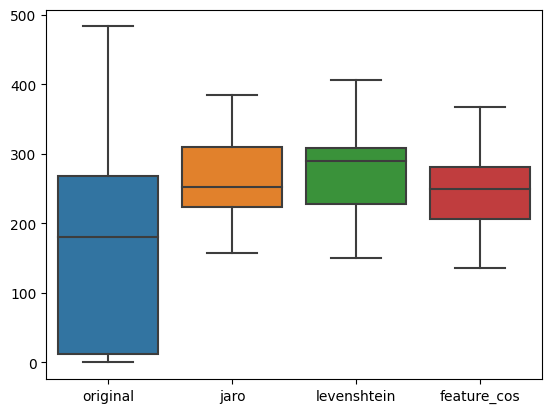

In [22]:
import seaborn as sns
import pandas as pd
sns.boxplot(data =  pd.DataFrame([normal_list, jaro_list, levenshtein_list, cos_list, ],
              index =["original", "jaro","levenshtein", "feature_cos", ]).T, )